<a href="https://colab.research.google.com/github/ChristianVo55/MachineLearning/blob/main/20240822_Mitarbeiterzuordnung_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zuordnung der Springer zu den Typenkennzeichen

Ziel: Minimierung der Leerlaufzeiten

Ansatz: Genetischer Algorithmus

Missing: Berücksichtigung des Arbeitsplatzes - also wenig wechsel von einem     Arbeitsplatz zum anderen Arbeitsplaz / Was passiert mit Aufgaben für die keiner eine Quali besitzt?

Lösungsansatz: Rotation der Mitarbeiter / Mitarbeiter frei lassen, also mit N/A oder so benennen


In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.3 MB/s eta 0:00:00


In [ ]:
import random
import pandas as pd
from deap import base, creator, tools, algorithms
from multiprocessing import Pool

# Datei laden
df = pd.read_excel('20240814_1621ac39-969d-48d4-b99d-456127a27b05_output.xlsx')
sheet2 = pd.read_excel('20240814_1621ac39-969d-48d4-b99d-456127a27b05_output.xlsx', sheet_name=1)

# Relevante Spalten extrahieren und aufbereiten
relevante_daten = df[['Mitarbeiter', 'Auftrag', 'Typenkennzeichnung', 'Startzeit', 'Endzeit', 'Arbeitszeit']].dropna(subset=['Typenkennzeichnung'])

# Typenkennzeichnung in String umwandeln
relevante_daten['Typenkennzeichnung'] = relevante_daten['Typenkennzeichnung'].astype(str)

# Zeitspalten formatieren und Arbeitszeit in Minuten umwandeln
relevante_daten['Startzeit'] = pd.to_datetime(relevante_daten['Startzeit'])
relevante_daten['Endzeit'] = pd.to_datetime(relevante_daten['Endzeit'])

def time_to_minutes(t):
    if isinstance(t, str):
        parts = t.split(':')
        return int(parts[0]) * 60 + int(parts[1]) + int(parts[2]) / 60
    elif isinstance(t, pd.Timestamp):
        return t.hour * 60 + t.minute + t.second / 60
    else:
        return t.hour * 60 + t.minute + t.second / 60

relevante_daten['Arbeitszeit_in_Minuten'] = relevante_daten['Arbeitszeit'].apply(time_to_minutes)

# Qualifikationen aus dem zweiten Arbeitsblatt extrahieren
qualifikationen = sheet2.set_index('Mitarbeiter')['Qualifikationen '].apply(lambda x: x.split(';')).to_dict()
mitarbeiter = list(qualifikationen.keys())

# Sicherstellen, dass die Klassen nicht mehrfach erstellt werden
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Jede Aufgabe wird jetzt durch eine Kombination aus Auftragsnummer und Typenkennzeichnung dargestellt
aufgaben = relevante_daten[['Auftrag', 'Typenkennzeichnung']].values.tolist()
# Dynamische Umwandlung der Liste in ein Dictionary
aufgaben_dict = {}
for auftrag, typenkennzeichen in aufgaben:
    if auftrag not in aufgaben_dict:
        aufgaben_dict[auftrag] = []
    aufgaben_dict[auftrag].append(typenkennzeichen)

# Effiziente Datenstruktur erstellen
relevante_daten_dict = relevante_daten.set_index(['Mitarbeiter', 'Auftrag', 'Typenkennzeichnung']).to_dict('index')

def create_individual():
    individual = []
    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            individual.append(random.choice(mitarbeiter))  # Zuweisung eines Mitarbeiters zur Aufgabe
    return individual

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitnessfunktion mit Berücksichtigung der Qualifikationen und der Doppelverplanung
def evaluate_with_qualifications_and_no_overlap(individual):
    leerlaufzeit = 0
    penalties = 0
    # Tell the function to use the global mitarbeiter variable
    global mitarbeiter
    mitarbeiter_zeitplan = {m: [] for m in mitarbeiter}
    idx = 0
    max_penalty = 2000  # Sehr hohe Strafe für nicht reparierbare Lösungen

    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            mitarbeiter = individual[idx]
            idx += 1

            if mitarbeiter == 'N/A':
              penalties += 250  # Sehr hohe Strafe für N/A-Zuordnung
            # Überprüfen, ob der Mitarbeiter für die Aufgabe qualifiziert ist
            elif typenkennzeichen not in qualifikationen.get(mitarbeiter, []):
                penalties += 500 # Höhere Strafe für ungültige Zuordnung - Ursprünglich bei 10
                #if penalties > max_penalty:
                return penalties, #+ leerlaufzeit,
            else:
                # Effizienter Zugriff auf die Daten
                relevant_data = relevante_daten_dict.get((mitarbeiter, auftragsnummer, typenkennzeichen))

                if relevant_data is None:
                    penalties += 100  # zusätzliche Strafe, wenn keine Daten vorhanden sind
                else:
                    startzeit = relevant_data['Startzeit'] #.values[0] Bin ich mir unsicher
                    endzeit = relevant_data['Endzeit'] #.values[0]

                    # Überprüfen auf Doppelverplanung (Zeitüberschneidungen)
                    for (s, e) in mitarbeiter_zeitplan[mitarbeiter]:
                        if not (endzeit <= s or startzeit >= e):  # Zeitüberschneidung
                            penalties += 500  # Extrem hohe Strafe für Doppelverplanung
                            return penalties,  # Sofort zurückgeben und nicht weiter berechnen
                            #penalties += 1000  # Höhere Strafe für Doppelverplanung - Ursprünglich bei 20
                            #if penalties > max_penalty:
                            #    return penalties, #+ leerlaufzeit,
                            #break

                    # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
                    mitarbeiter_zeitplan[mitarbeiter].append((startzeit, endzeit))

                    # Leerlaufzeit hinzufügen
                    leerlaufzeit += relevant_data['Arbeitszeit_in_Minuten'] #.values[0]

    return leerlaufzeit + penalties,

def repair_individual(individual):
    global mitarbeiter
    mitarbeiter_zeitplan = {m: [] for m in mitarbeiter}
    idx = 0

    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            mitarbeiter = individual[idx]
            relevant_data = relevante_daten_dict.get((mitarbeiter, auftragsnummer, typenkennzeichen))
            if relevant_data is not None:
                startzeit = relevant_data['Startzeit']
                endzeit = relevant_data['Endzeit']
                doppelverplant = False

                # Überprüfen, ob der aktuelle Mitarbeiter bereits anderweitig verplant ist
                for (s, e) in mitarbeiter_zeitplan[mitarbeiter]:
                    if not (endzeit <= s or startzeit >= e):
                        doppelverplant = True
                        break

                if doppelverplant:
                    # Finden eines neuen Mitarbeiters mit den richtigen Qualifikationen und ohne Zeitüberschneidung
                    mögliche_mitarbeiter = [
                        m for m in mitarbeiter
                        if typenkennzeichen in qualifikationen.get(m, []) and
                        all(endzeit <= s or startzeit >= e for (s, e) in mitarbeiter_zeitplan[m])
                    ]

                    if mögliche_mitarbeiter:
                        new_mitarbeiter = random.choice(mögliche_mitarbeiter)
                        individual[idx] = new_mitarbeiter
                    else:
                        # Letzter Ausweg: Versuche, den Konflikt mit einem beliebigen anderen Mitarbeiter zu lösen,
                        # der in dieser Zeit nicht verplant ist
                        andere_mitarbeiter = [
                            m for m in mitarbeiter
                            if m != individual[idx] and
                            all(endzeit <= s or startzeit >= e for (s, e) in mitarbeiter_zeitplan[m])
                        ]
                        if andere_mitarbeiter:
                            individual[idx] = random.choice(andere_mitarbeiter)
                        else:
                            # Falls kein qualifizierter oder verfügbarer Mitarbeiter gefunden wird, setze "N/A"
                            individual[idx] = 'N/A'

                # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
                if individual[idx] != 'N/A':
                    mitarbeiter_zeitplan[individual[idx]].append((startzeit, endzeit))
            idx += 1
    return individual

# Fitness Cache verwenden
fitness_cache = {}

def evaluate_with_cache(individual):
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]
    else:
        individual = repair_individual(individual)  # Anwenden der Reparaturfunktion
        result = evaluate_with_qualifications_and_no_overlap(individual)
        fitness_cache[key] = result
        return result

# Pool für Parallelisierung
pool = Pool()
toolbox.register("map", pool.map)
toolbox.register("evaluate", evaluate_with_cache)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=7)

# Genetischen Algorithmus ausführen
population = toolbox.population(n=3000) # n = 100
NGEN = 2000 # NGEN = 50
CXPB = 0.9 # CXPB = 0.8
MUTPB = 0.2 # MUTPB = 0.3

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

    # Reparaturfunktion auf jeden Nachkommen nach der Mutation anwenden
    #offspring = list(map(repair_individual, offspring))

    # Fitness bewerten
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    # Selektion der neuen Population
    population = toolbox.select(offspring, k=len(population))

# Beste Lösung anzeigen
best_ind = tools.selBest(population, 1)[0]
print('Beste Zuordnung:', best_ind)
print('Fitness-Wert:', best_ind.fitness.values)

# Berechnung der Anzahl der 'N/A' Einträge in der besten Lösung
na_count = best_ind.count('N/A')
print(f"Anzahl der 'N/A'-Einträge: {na_count}")

# Pool schließen
pool.close()
pool.join()

In [267]:
# Nachbesserungsfunktion für individuelle Lösungen - Doppelverplanung unter Berücksichtigung der Qualifikation
def repair_individual(individual):
    global mitarbeiter
    mitarbeiter_zeitplan = {m: [] for m in mitarbeiter}
    idx = 0

    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            mitarbeiter = individual[idx]
            relevant_data = relevante_daten_dict.get((mitarbeiter, auftragsnummer, typenkennzeichen))
            if relevant_data is not None:
                startzeit = relevant_data['Startzeit']
                endzeit = relevant_data['Endzeit']
                doppelverplant = False

                for (s, e) in mitarbeiter_zeitplan[mitarbeiter]:
                    if not (endzeit <= s or startzeit >= e):
                        doppelverplant = True
                        break

                if doppelverplant:
                    # Finden eines neuen Mitarbeiters mit den richtigen Qualifikationen
                    mögliche_mitarbeiter = [m for m in mitarbeiter if typenkennzeichen in qualifikationen.get(m, [])]

                    if mögliche_mitarbeiter:
                        new_mitarbeiter = random.choice(mögliche_mitarbeiter)
                        individual[idx] = new_mitarbeiter
                    else:
                        # Letzter Ausweg: Versuche, den Konflikt mit einem beliebigen anderen Mitarbeiter zu lösen
                        andere_mitarbeiter = [m for m in mitarbeiter if m != individual[idx]]
                        if andere_mitarbeiter:
                            individual[idx] = random.choice(andere_mitarbeiter)
                        else:
                            # Falls kein qualifizierter oder anderer Mitarbeiter gefunden wird, setze "N/A"
                            individual[idx] = 'N/A'

                # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
                if individual[idx] != 'N/A':
                    mitarbeiter_zeitplan[mitarbeiter].append((startzeit, endzeit))
            idx += 1
    return individual

Arbeitszeit und Leerlaufzeit mit Optimierung visualisieren



Mitarbeiter Arbeitszeit und Leerlaufzeit:
Fuchs : Arbeitszeit: 01:07:37, Leerlaufzeit: 06:22:22
Gezdirici: Arbeitszeit: 05:40:11, Leerlaufzeit: 01:49:48
Ostendarp: Arbeitszeit: 05:38:26, Leerlaufzeit: 01:51:33
Severt: Arbeitszeit: 04:50:06, Leerlaufzeit: 02:39:53
Beste Zuordnung: ['Gezdirici', 'Severt', 'Ostendarp', 'Ostendarp', 'Ostendarp', 'Severt', 'Severt', 'Gezdirici', 'Ostendarp', 'Severt', 'Severt', 'Severt', 'Gezdirici', 'Gezdirici', 'Ostendarp', 'Severt', 'Severt', 'Ostendarp', 'Severt', 'Ostendarp', 'Ostendarp', 'Ostendarp', 'Severt', 'Gezdirici', 'Ostendarp', 'Severt', 'Gezdirici', 'Fuchs ', 'Gezdirici', 'Gezdirici', 'Gezdirici', 'Severt', 'Gezdirici', 'Ostendarp', 'Severt', 'Gezdirici', 'Ostendarp', 'Severt', 'Ostendarp', 'Severt', 'Fuchs ', 'Gezdirici', 'Ostendarp', 'Ostendarp', 'Fuchs ', 'Severt', 'Ostendarp', 'Gezdirici', 'Severt', 'Gezdirici', 'Gezdirici', 'Severt', 'Ostendarp', 'Ostendarp', 'Ostendarp', 'Ostendarp', 'Ostendarp', 'Gezdirici', 'Gezdirici', 'Fuchs ', 'Fuc

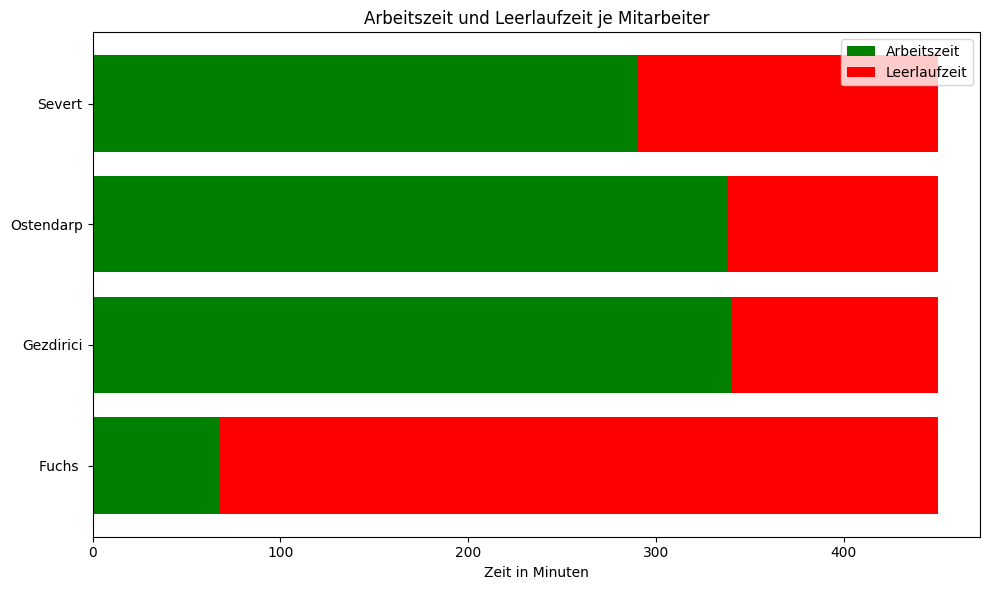

In [292]:
import matplotlib.pyplot as plt

# Funktion zur Umwandlung von Minuten in hh:mm:ss Format
def minutes_to_hhmmss(minutes):
    hours = int(minutes // 60)
    minutes = minutes % 60
    full_minutes = int(minutes)  # Ganze Minuten
    seconds = int((minutes - full_minutes) * 60)  # Rest als Sekunden
    return f"{hours:02}:{full_minutes:02}:{seconds:02}"

# Nach der Selektion der besten Lösung:
best_ind = tools.selBest(population, 1)[0]

# Liste der Mitarbeiter in Reihenfolge der Aufgaben
mitarbeiter_list = list(qualifikationen.keys())
arbeitszeit_dict = {m: 0 for m in mitarbeiter_list}  # Initialisiere Arbeitszeit für jeden Mitarbeiter

# Füge die beste Zuordnung der Mitarbeiter in die Tabelle "relevante_daten" ein
for idx, (auftragsnummer, typenkennzeichen) in enumerate(aufgaben):
    mitarbeiter_name = best_ind[idx]
    # Mitarbeiterzuordnung in die Tabelle einfügen
    relevante_daten.loc[
        (relevante_daten['Auftrag'] == auftragsnummer) &
        (relevante_daten['Typenkennzeichnung'] == typenkennzeichen),
        'Mitarbeiter'
    ] = mitarbeiter_name

# Berechnung der Arbeits- und Leerlaufzeit für jeden Mitarbeiter
for idx, mitarbeiter_name in enumerate(best_ind):
    auftragsnummer, typenkennzeichen = aufgaben[idx]

    # Hole die relevanten Daten für diese Aufgabe
    relevant_data = relevante_daten[
        (relevante_daten['Mitarbeiter'] == mitarbeiter_name) &
        (relevante_daten['Auftrag'] == auftragsnummer) &
        (relevante_daten['Typenkennzeichnung'] == typenkennzeichen)
    ]

    if not relevant_data.empty:
        arbeitszeit_dict[mitarbeiter_name] += relevant_data['Arbeitszeit_in_Minuten'].values[0]

# Gesamte verfügbare Arbeitszeit an einem Tag (7 Stunden und 30 Minuten)
gesamt_arbeitszeit = 7 * 60 + 30  # 450 Minuten

# Berechnung der Leerlaufzeit und Darstellung der Arbeits- und Leerlaufzeit
arbeitszeiten = []
leerlaufzeiten = []
mitarbeiter_namen = []

print("Mitarbeiter Arbeitszeit und Leerlaufzeit:")
for m in mitarbeiter_list:
    arbeitszeit = arbeitszeit_dict[m]
    leerlaufzeit = gesamt_arbeitszeit - arbeitszeit
    arbeitszeiten.append(arbeitszeit)
    leerlaufzeiten.append(leerlaufzeit)
    mitarbeiter_namen.append(m)
    print(f"{m}: Arbeitszeit: {minutes_to_hhmmss(arbeitszeit)}, Leerlaufzeit: {minutes_to_hhmmss(leerlaufzeit)}")

# Visualisierung der Arbeits- und Leerlaufzeiten
fig, ax = plt.subplots(figsize=(10, 6))

# Stapeldiagramm für Arbeitszeit und Leerlaufzeit
ax.barh(mitarbeiter_namen, arbeitszeiten, color='green', label='Arbeitszeit')
ax.barh(mitarbeiter_namen, leerlaufzeiten, left=arbeitszeiten, color='red', label='Leerlaufzeit')

ax.set_xlabel('Zeit in Minuten')
ax.set_title('Arbeitszeit und Leerlaufzeit je Mitarbeiter')
ax.legend()

# Ausgabe des Fitness-Werts
print('Beste Zuordnung:', best_ind)
print('Fitness-Wert:', best_ind.fitness.values)

# Plot anzeigen
plt.tight_layout()
plt.show()

In [ ]:
for idx, (auftragsnummer, typenkennzeichen_liste) in enumerate(aufgaben_dict.items()):
    print(idx)
    print(auftragsnummer)
    print(typenkennzeichen_liste)
    for typenkennzeichen in typenkennzeichen_liste:
        print(typenkennzeichen)
        print(best_ind[idx])
        mitarbeiter_name = best_ind[idx]


In [71]:
flat_list = [item for sublist in list(aufgaben_dict.values()) for item in sublist]

# Arbeitszeit und Leerlaufzeit ohne Optimierung

In [106]:
# Datei laden
df_OP = pd.read_excel('20240814_Ohne Optimierung.xlsx')

# Relevante Spalten extrahieren und aufbereiten
relevante_daten_OP = df_OP[['Mitarbeiter', 'Auftrag', 'Typenkennzeichnung', 'Startzeit', 'Endzeit', 'Arbeitszeit', 'ArbeitszeitRealtime']].dropna(subset=['Typenkennzeichnung'])
relevante_daten_OP.head()

,Mitarbeiter,Auftrag,Typenkennzeichnung,Startzeit,Endzeit,Arbeitszeit,ArbeitszeitRealtime
1,Fuchs,61308673,123,2024-08-14T12:00:00.000Z,2024-08-14T12:12:55.000Z,00:12:55,12.92
2,Severt,61308673,153_4,2024-08-14T12:14:15.000Z,2024-08-14T12:15:27.000Z,00:01:12,1.20
3,Severt,61308673,154_4,2024-08-14T12:15:27.000Z,2024-08-14T12:16:30.000Z,00:01:03,1.05
4,Severt,61308673,89,2024-08-14T12:16:30.000Z,2024-08-14T12:20:29.000Z,00:03:59,3.98
6,Fuchs,61310383,123,2024-08-14T12:14:15.000Z,2024-08-14T12:27:10.000Z,00:12:55,12.92


Mitarbeiter Arbeitszeit und Leerlaufzeit ohne Optimierung:
Fuchs : Arbeiszeit ohne Optimierung: 06:22:00, Leerlaufzeit ohne Optimierung: 01:07:59
Gezdirici: Arbeiszeit ohne Optimierung: 00:53:21, Leerlaufzeit ohne Optimierung: 06:36:38
Ostendarp: Arbeiszeit ohne Optimierung: 03:58:39, Leerlaufzeit ohne Optimierung: 03:31:20
Severt: Arbeiszeit ohne Optimierung: 05:28:25, Leerlaufzeit ohne Optimierung: 02:01:34
NichtZugewiesen: Arbeiszeit ohne Optimierung: 00:34:29, Leerlaufzeit ohne Optimierung: 06:55:30


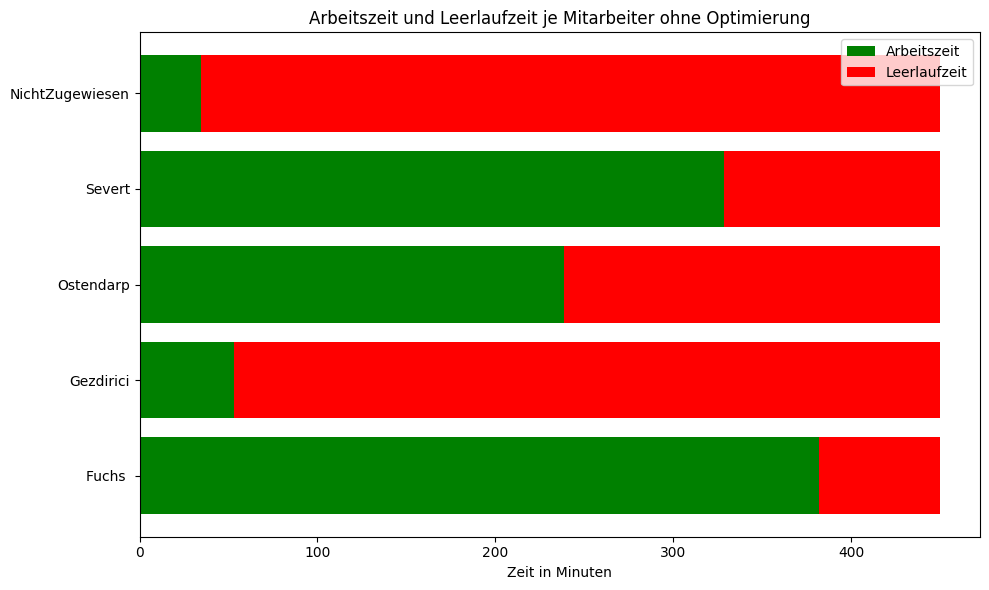

In [128]:
# Liste der Mitarbeiter in Reihenfolge der Aufgaben
mitarbeiter_list_OP = list(qualifikationen.keys())
mitarbeiter_list_OP.append('NichtZugewiesen')
arbeitszeit_dict_OP = {m: 0 for m in mitarbeiter_list_OP}  # Initialisiere Arbeitszeit für jeden Mitarbeiter


# Berechnung der Arbeits- und Leerlaufzeit für jeden Mitarbeiter
for row in relevante_daten_OP.iterrows(): # Iterate over rows with index
    auftragsnummer_OP = row[1]['Auftrag']
    typenkennzeichen_OP = row[1]['Typenkennzeichnung']
    mitarbeiter_name_OP = row[1]['Mitarbeiter']
    try:
        arbeitszeit_dict_OP[mitarbeiter_name_OP] += row[1]['ArbeitszeitRealtime']
    except:
        arbeitszeit_dict_OP['NichtZugewiesen'] += row[1]['ArbeitszeitRealtime']

# Berechnung der Leerlaufzeit und Darstellung der Arbeits- und Leerlaufzeit
arbeitszeiten_OP = []
leerlaufzeiten_OP = []
mitarbeiter_namen_OP = []

print("Mitarbeiter Arbeitszeit und Leerlaufzeit ohne Optimierung:")
for m in mitarbeiter_list_OP:
    arbeitszeit_OP = arbeitszeit_dict_OP[m]
    leerlaufzeit_OP = gesamt_arbeitszeit - arbeitszeit_OP
    arbeitszeiten_OP.append(arbeitszeit_OP)
    leerlaufzeiten_OP.append(leerlaufzeit_OP)
    mitarbeiter_namen_OP.append(m)
    print(f"{m}: Arbeiszeit ohne Optimierung: {minutes_to_hhmmss(arbeitszeit_OP)}, Leerlaufzeit ohne Optimierung: {minutes_to_hhmmss(leerlaufzeit_OP)}")

# Visualisierung der Arbeits- und Leerlaufzeiten
fig, ax = plt.subplots(figsize=(10, 6))

# Stapeldiagramm für Arbeitszeit und Leerlaufzeit
ax.barh(mitarbeiter_namen_OP, arbeitszeiten_OP, color='green', label='Arbeitszeit')
ax.barh(mitarbeiter_namen_OP, leerlaufzeiten_OP, left=arbeitszeiten_OP, color='red', label='Leerlaufzeit')

ax.set_xlabel('Zeit in Minuten')
ax.set_title('Arbeitszeit und Leerlaufzeit je Mitarbeiter ohne Optimierung')
ax.legend()

# Plot anzeigen
plt.tight_layout()
plt.show()

# Validierung

Validierung der Qualifikatioen

In [293]:
# Validierung der Qualifikationen
fehlerhafte_zuweisungen = []
for idx, (auftragsnummer, typenkennzeichen) in enumerate(aufgaben):
    mitarbeiter_name = best_ind[idx]
    if typenkennzeichen not in qualifikationen.get(mitarbeiter_name, []):
        fehlerhafte_zuweisungen.append((mitarbeiter_name, auftragsnummer, typenkennzeichen))

# Ergebnis der Validierung ausgeben
if fehlerhafte_zuweisungen:
    print(f"{len(fehlerhafte_zuweisungen)} fehlerhafte Zuweisungen gefunden! Folgende Mitarbeiter wurden Aufgaben zugewiesen, für die sie nicht qualifiziert sind:")
    for zuweisung in fehlerhafte_zuweisungen:
        print(f"Mitarbeiter: {zuweisung[0]}, Auftragsnummer: {zuweisung[1]}, Typenkennzeichen: {zuweisung[2]}")
else:
    print("Alle Zuweisungen sind korrekt. Jeder Mitarbeiter wurde nur Aufgaben zugewiesen, für die er qualifiziert ist.")

80 fehlerhafte Zuweisungen gefunden! Folgende Mitarbeiter wurden Aufgaben zugewiesen, für die sie nicht qualifiziert sind:
Mitarbeiter: Gezdirici, Auftragsnummer: 61308673, Typenkennzeichen: 123
Mitarbeiter: Ostendarp, Auftragsnummer: 61308673, Typenkennzeichen: 154_4
Mitarbeiter: Ostendarp, Auftragsnummer: 61310383, Typenkennzeichen: 123
Mitarbeiter: Severt, Auftragsnummer: 61310383, Typenkennzeichen: 03_4
Mitarbeiter: Gezdirici, Auftragsnummer: 61310383, Typenkennzeichen: 171
Mitarbeiter: Ostendarp, Auftragsnummer: 61310389, Typenkennzeichen: 123
Mitarbeiter: Severt, Auftragsnummer: 61310389, Typenkennzeichen: 466_1
Mitarbeiter: Severt, Auftragsnummer: 61310389, Typenkennzeichen: 540
Mitarbeiter: Gezdirici, Auftragsnummer: 61310389, Typenkennzeichen: 153
Mitarbeiter: Gezdirici, Auftragsnummer: 61310389, Typenkennzeichen: 171
Mitarbeiter: Severt, Auftragsnummer: 61307650, Typenkennzeichen: 123
Mitarbeiter: Severt, Auftragsnummer: 61309053, Typenkennzeichen: K79212
Mitarbeiter: Ostenda

Validierung der Doppelverplanung

In [294]:
# Überprüfung auf Doppelverplanungen
doppelverplanungen = []
mitarbeiter_zeitplan = {m: [] for m in mitarbeiter_list}

for idx, (auftragsnummer, typenkennzeichen) in enumerate(aufgaben):
    mitarbeiter_name = best_ind[idx]

    # Hole die relevanten Daten für diese Aufgabe
    relevant_data = relevante_daten[
        (relevante_daten['Mitarbeiter'] == mitarbeiter_name) &
        (relevante_daten['Auftrag'] == auftragsnummer) &
        (relevante_daten['Typenkennzeichnung'] == typenkennzeichen)
    ]

    if not relevant_data.empty:
        startzeit = relevant_data['Startzeit'].values[0]
        endzeit = relevant_data['Endzeit'].values[0]

        # Überprüfen auf Doppelverplanung (Zeitüberschneidungen)
        for (s, e) in mitarbeiter_zeitplan[mitarbeiter_name]:
            if not (endzeit <= s or startzeit >= e):  # Zeitüberschneidung
                doppelverplanungen.append((mitarbeiter_name, auftragsnummer, typenkennzeichen, startzeit, endzeit))
                break

        # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
        mitarbeiter_zeitplan[mitarbeiter_name].append((startzeit, endzeit))

# Ergebnis der Überprüfung auf Doppelverplanungen ausgeben
if doppelverplanungen:
    print(f"{len(doppelverplanungen)} Doppelverplanungen gefunden! Folgende Mitarbeiter wurden Aufgaben mit überlappenden Zeiten zugewiesen:")
    for doppel in doppelverplanungen:
        print(f"Mitarbeiter: {doppel[0]}, Auftragsnummer: {doppel[1]}, Typenkennzeichen: {doppel[2]}, Startzeit: {doppel[3]}, Endzeit: {doppel[4]}")
else:
    print("Keine Doppelverplanungen gefunden. Jeder Mitarbeiter wurde nur einer Aufgabe zur selben Zeit zugewiesen.")

42 Doppelverplanungen gefunden! Folgende Mitarbeiter wurden Aufgaben mit überlappenden Zeiten zugewiesen:
Mitarbeiter: Ostendarp, Auftragsnummer: 61310383, Typenkennzeichen: 123, Startzeit: 2024-08-14T12:14:15.000000000, Endzeit: 2024-08-14T12:27:10.000000000
Mitarbeiter: Severt, Auftragsnummer: 61310389, Typenkennzeichen: 466_1, Startzeit: 2024-08-14T12:31:30.000000000, Endzeit: 2024-08-14T12:52:38.000000000
Mitarbeiter: Severt, Auftragsnummer: 61310389, Typenkennzeichen: F31997_1, Startzeit: 2024-08-14T12:35:30.000000000, Endzeit: 2024-08-14T12:41:45.000000000
Mitarbeiter: Ostendarp, Auftragsnummer: 61307650, Typenkennzeichen: 187, Startzeit: 2024-08-14T12:35:20.000000000, Endzeit: 2024-08-14T12:39:16.000000000
Mitarbeiter: Severt, Auftragsnummer: 61307650, Typenkennzeichen: 123, Startzeit: 2024-08-14T12:42:45.000000000, Endzeit: 2024-08-14T12:55:40.000000000
Mitarbeiter: Severt, Auftragsnummer: 61309053, Typenkennzeichen: K79212, Startzeit: 2024-08-14T12:40:45.000000000, Endzeit: 20

# Debuggen

In [ ]:
for idx, (auftragsnummer, typenkennzeichen) in enumerate(aufgaben):
    print(f"Index: {idx}")
    print(f"Auftragsnummer: {auftragsnummer}")
    print(f"Typenkennzeichen: {typenkennzeichen}")
    print(f"Zugeordneter Mitarbeiter: {best_ind[idx]}")
    mitarbeiter_name = best_ind[idx]

    # Hole die relevanten Daten für diese Aufgabe
    relevant_data = relevante_daten[
        #(relevante_daten['Mitarbeiter'] == mitarbeiter_name) &
        (relevante_daten['Auftrag'] == auftragsnummer) &
        (relevante_daten['Typenkennzeichnung'] == typenkennzeichen)
    ]

    # Debugging-Ausgabe, wenn relevant_data leer ist
    if relevant_data.empty:
        print("WARNUNG: Keine Übereinstimmungen gefunden")
        print(f"Mitarbeiter: {mitarbeiter_name}")
        print(f"Auftragsnummer: {auftragsnummer}")
        print(f"Typenkennzeichen: {typenkennzeichen}")
        print(relevante_daten[['Mitarbeiter', 'Auftrag', 'Typenkennzeichnung']].drop_duplicates())

    if not relevant_data.empty:
        arbeitszeit_dict[mitarbeiter_name] += relevant_data['Arbeitszeit_in_Minuten'].values[0]


In [88]:
relevant_data

,Mitarbeiter,Auftrag,Typenkennzeichnung,Startzeit,Endzeit,Arbeitszeit,Arbeitszeit_in_Minuten
160,NaN,61312154,03_4,2024-08-14 19:20:25+00:00,2024-08-14 19:28:27+00:00,00:08:02,8.033333


In [ ]:
import random
import pandas as pd
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

# Datei laden und relevante Daten vorbereiten
df = pd.read_excel('path_to_your_file.xlsx')
sheet2 = pd.read_excel('path_to_your_file.xlsx', sheet_name=1)

relevante_daten = df[['Mitarbeiter', 'Auftrag', 'Typenkennzeichnung', 'Startzeit', 'Endzeit', 'Arbeitszeit']].dropna(subset=['Typenkennzeichnung'])
relevante_daten['Typenkennzeichnung'] = relevante_daten['Typenkennzeichnung'].astype(str)

# Zeitspalten formatieren und Arbeitszeit in Minuten umwandeln
relevante_daten['Startzeit'] = pd.to_datetime(relevante_daten['Startzeit'])
relevante_daten['Endzeit'] = pd.to_datetime(relevante_daten['Endzeit'])

def time_to_minutes(t):
    if isinstance(t, str):
        parts = t.split(':')
        return int(parts[0]) * 60 + int(parts[1]) + int(parts[2]) / 60
    elif isinstance(t, pd.Timestamp):
        return t.hour * 60 + t.minute + t.second / 60
    else:
        return t.hour * 60 + t.minute + t.second / 60

relevante_daten['Arbeitszeit_in_Minuten'] = relevante_daten['Arbeitszeit'].apply(time_to_minutes)

# Qualifikationen aus dem zweiten Arbeitsblatt extrahieren
qualifikationen = sheet2.set_index('Mitarbeiter')['Qualifikationen '].apply(lambda x: x.split(';')).to_dict()
mitarbeiter_list = list(qualifikationen.keys())

# Sicherstellen, dass die Klassen nicht mehrfach erstellt werden
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Jede Aufgabe wird jetzt durch eine Kombination aus Auftragsnummer und Typenkennzeichnung dargestellt
aufgaben = relevante_daten[['Auftrag', 'Typenkennzeichnung']].values.tolist()
# Dynamische Umwandlung der Liste in ein Dictionary
aufgaben_dict = {}
for auftrag, typenkennzeichen in aufgaben:
    if auftrag not in aufgaben_dict:
        aufgaben_dict[auftrag] = []
    aufgaben_dict[auftrag].append(typenkennzeichen)

# Die ursprüngliche Fitnessfunktion, die Doppelverplanungen und Qualifikationen berücksichtigt
def evaluate_with_qualifications_and_no_overlap(individual):
    leerlaufzeit = 0
    penalties = 0
    mitarbeiter_zeitplan = {m: [] for m in mitarbeiter_list}  # Zeitplan für jeden Mitarbeiter
    idx = 0

    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            mitarbeiter_name = individual[idx]
            idx += 1

            # Überprüfen, ob der Mitarbeiter für die Aufgabe qualifiziert ist
            if typenkennzeichen not in qualifikationen.get(mitarbeiter_name, []):
                penalties += 50  # Erhöhte Strafe für falsche Zuordnung
            else:
                relevant_data = relevante_daten[
                    (relevante_daten['Mitarbeiter'] == mitarbeiter_name) &
                    (relevante_daten['Auftrag'] == auftragsnummer) &
                    (relevante_daten['Typenkennzeichnung'] == typenkennzeichen)
                ]
                if relevant_data.empty:
                    penalties += 10  # Zusätzliche Strafe, wenn keine Daten vorhanden sind
                else:
                    startzeit = relevant_data['Startzeit'].values[0]
                    endzeit = relevant_data['Endzeit'].values[0]

                    # Überprüfen auf Doppelverplanung (Zeitüberschneidungen)
                    for (s, e) in mitarbeiter_zeitplan[mitarbeiter_name]:
                        if not (endzeit <= s or startzeit >= e):  # Zeitüberschneidung
                            penalties += 100  # Stark erhöhte Strafe für Doppelverplanung
                            break

                    # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
                    mitarbeiter_zeitplan[mitarbeiter_name].append((startzeit, endzeit))

                    # Leerlaufzeit hinzufügen
                    leerlaufzeit += relevant_data['Arbeitszeit_in_Minuten'].values[0]

    return leerlaufzeit + penalties,

# Fitness Cache verwenden
fitness_cache = {}

def evaluate_with_cache(individual):
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]
    else:
        result = evaluate_with_qualifications_and_no_overlap(individual)
        fitness_cache[key] = result
        return result

# Cache-basierte Fitnessfunktion registrieren
toolbox.register("evaluate", evaluate_with_cache)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetischen Algorithmus ausführen
population = toolbox.population(n=300)
NGEN = 200
CXPB = 0.7
MUTPB = 0.3

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Beste Lösung anzeigen und überprüfen
best_ind = tools.selBest(population, 1)[0]
print('Beste Zuordnung:', best_ind)
print('Fitness-Wert:', best_ind.fitness.values)

# Anschließend wird die Doppelverplanungs- und Qualifikationsvalidierung wie zuvor durchgeführt


# Speicherung des Codes

In [ ]:
# Sicherstellen, dass die Klassen nicht mehrfach erstellt werden
if not hasattr(creator, 'FitnessMin'):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Jede Aufgabe wird jetzt durch eine Kombination aus Auftragsnummer und Typenkennzeichnung dargestellt
aufgaben = relevante_daten[['Auftrag', 'Typenkennzeichnung']].values.tolist()
# Dynamische Umwandlung der Liste in ein Dictionary
aufgaben_dict = {}
for auftrag, typenkennzeichen in aufgaben:
    if auftrag not in aufgaben_dict:
        aufgaben_dict[auftrag] = []
    aufgaben_dict[auftrag].append(typenkennzeichen)

def create_individual():
    individual = []
    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            individual.append(random.choice(mitarbeiter))  # Zuweisung eines Mitarbeiters zur Aufgabe
    return individual

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitnessfunktion mit Berücksichtigung der Qualifikationen und der Doppelverplanung
def evaluate_with_qualifications_and_no_overlap(individual):
    leerlaufzeit = 0
    penalties = 0
    # Tell the function to use the global mitarbeiter variable
    global mitarbeiter
    mitarbeiter_zeitplan = {m: [] for m in mitarbeiter}
    idx = 0
    max_penalty = 1000  # Beispiel für eine Abbruchschwelle

    for auftragsnummer, typenkennzeichen_liste in aufgaben_dict.items():
        for typenkennzeichen in typenkennzeichen_liste:
            mitarbeiter = individual[idx]
            idx += 1

            # Überprüfen, ob der Mitarbeiter für die Aufgabe qualifiziert ist
            if typenkennzeichen not in qualifikationen.get(mitarbeiter, []):
                penalties += 100  # Strafe für falsche Zuordnung - Ursprünglich bei 10
                if penalties > max_penalty:
                    return penalties + leerlaufzeit,
            else:
                relevant_data = relevante_daten[
                    (relevante_daten['Mitarbeiter'] == mitarbeiter) &
                    (relevante_daten['Auftrag'] == auftragsnummer) &
                    (relevante_daten['Typenkennzeichnung'] == typenkennzeichen)
                ]
                if relevant_data.empty:
                    penalties += 10  # zusätzliche Strafe, wenn keine Daten vorhanden sind
                else:
                    startzeit = relevant_data['Startzeit'].values[0]
                    endzeit = relevant_data['Endzeit'].values[0]

# Überprüfen auf Doppelverplanung (Zeitüberschneidungen)
                    for (s, e) in mitarbeiter_zeitplan[mitarbeiter]:
                        if not (endzeit <= s or startzeit >= e):  # Zeitüberschneidung
                            penalties += 100  # Höhere Strafe für Doppelverplanung - Ursprünglich bei 20
                            if penalties > max_penalty:
                                return penalties + leerlaufzeit,
                            break

                    # Falls keine Überschneidung, Zeitbereich zum Zeitplan hinzufügen
                    mitarbeiter_zeitplan[mitarbeiter].append((startzeit, endzeit))

                    # Leerlaufzeit hinzufügen
                    leerlaufzeit += relevant_data['Arbeitszeit_in_Minuten'].values[0]

    return leerlaufzeit + penalties,

# Fitness Cache verwenden
fitness_cache = {}

def evaluate_with_cache(individual):
    key = tuple(individual)
    if key in fitness_cache:
        return fitness_cache[key]
    else:
        result = evaluate_with_qualifications_and_no_overlap(individual)
        fitness_cache[key] = result
        return result

toolbox.register("evaluate", evaluate_with_qualifications_and_no_overlap)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetischen Algorithmus ausführen
population = toolbox.population(n=300) # n = 100
NGEN = 200 # NGEN = 50
CXPB = 0.7 # CXPB = 0.8
MUTPB = 0.3 # MUTPB = 0.3

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Beste Lösung anzeigen
best_ind = tools.selBest(population, 1)[0]
print('Beste Zuordnung:', best_ind)
print('Fitness-Wert:', best_ind.fitness.values)